In [29]:
import os
import sys

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

from PIL import Image

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from random import randint

In [55]:
emotions = [
    'angry',
    'disgust',
    'fear',
    'happy',
    'neutral',
    'sad',
    'surprise'
]

In [54]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, emotions, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.images = []
        self.labels = []

        for i, emotion in enumerate(emotions):
            emotion_dir = os.path.join(root_dir, emotion)
            if os.path.isdir(emotion_dir):  # Ensure it's a directory
                for image_name in os.listdir(emotion_dir):
                    image_path = os.path.join(emotion_dir, image_name)
                    self.images.append(image_path)
                    self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('L')  # Open as grayscale
        # Convert to tensor
        image = transforms.ToTensor()(image)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [18]:
class EmotionClassifier(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionClassifier, self).__init__()
        
        # Load the pre-trained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)

        # Modify the ResNet model to accept grayscale images
        # Change the first convolution layer to accept 1 channel instead of 3
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Remove the final fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # Remove the last layer

        # Add additional layers: 2 fully connected layers and an output layer
        self.fc1 = nn.Linear(2048, 512)  # 2048 is the output of the last ResNet layer
        self.fc2 = nn.Linear(512, num_classes)

        # Optional: Add dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Forward pass through the ResNet backbone
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Flatten the output from ResNet

        # Forward pass through the additional fully connected layers
        x = self.dropout(self.fc1(x))
        x = nn.ReLU()(x)
        x = self.fc2(x)
        
        return x

In [ ]:

# Define constants
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
NUM_CLASSES = 7
ROOT_DIR = './images'  # Adjust based on your dataset structure

# Define data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for grayscale
])

# Initialize datasets and dataloaders
train_dataset = EmotionDataset(root_dir=os.path.join(ROOT_DIR, 'train'), emotions=emotions, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = EmotionDataset(root_dir=os.path.join(ROOT_DIR, 'validation'), emotions=emotions, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize the model, loss function, and optimizer
model = EmotionClassifier(num_classes=NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Check if GPU is available
# device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Use tqdm to create a progress bar for training
    with tqdm(total=len(train_loader), desc=f'Training Epoch {epoch + 1}/{NUM_EPOCHS}', unit='batch') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / (pbar.n + 1))  # Update loss in the progress bar
            pbar.update(1)  # Increment the progress bar

    # Average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}')

    # Validation
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    # Use tqdm to create a progress bar for validation
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc='Validation', unit='batch') as pbar:
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.update(1)  # Increment the progress bar

    # Calculate accuracy
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

print('Training Complete!')

/opt/anaconda3/envs/unet/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/unet/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Epoch 1/50:  25%|██▍       | 221/901 [00:24<01:14,  9.12batch/s, loss=1.84]


KeyboardInterrupt: 

In [41]:
emotions

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [49]:
test_dataset[r]

(tensor([[[ 0.6941,  0.6706,  0.6627,  ..., -0.7569, -0.6392, -0.2863],
          [ 0.6941,  0.7176,  0.6706,  ..., -0.8118, -0.7882, -0.4667],
          [ 0.6706,  0.7098,  0.7412,  ..., -0.8667, -0.8118, -0.4275],
          ...,
          [ 0.8824,  0.9216,  0.9216,  ...,  0.4353,  0.4039,  0.4275],
          [ 0.8745,  0.8824,  0.9216,  ...,  0.4196,  0.4118,  0.4588],
          [ 0.9294,  0.8667,  0.8980,  ...,  0.4745,  0.4745,  0.4824]]]),
 0)

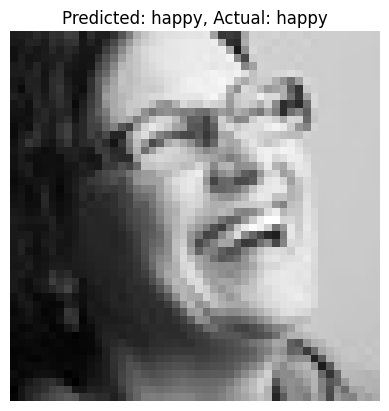

In [60]:
# make new predictions
model.eval()
test_dataset = EmotionDataset(root_dir=os.path.join(ROOT_DIR, 'validation'), emotions=emotions, transform=transform)

r = randint(0, len(test_dataset) - 1)

# Select a random image from the dataset
image, label = test_dataset[r]
image = image.unsqueeze(0).to(device)

# Perform a forward pass
output = model(image)
_, predicted = torch.max(output.data, 1)

plt.figure()
plt.imshow(image.cpu().squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Predicted: {emotions[predicted.item()]}, Actual: {emotions[label]}')
plt.show()